In [209]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import os
from pyproj import Transformer
from scipy.spatial import cKDTree
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print(os.getcwd())

/home/franc/Desktop/ProjIntegrador


In [4]:
apa2017 = pd.read_excel('apa/PM10_2017-01-01_2017-12-31.xlsx', header=0)
apa2018 = pd.read_excel('apa/PM10_2018-01-01_2018-12-31.xlsx', header=0)

In [5]:
print(f"Apa 2017 dimensões: {apa2017.shape}")
print(apa2017.head())

Apa 2017 dimensões: (8760, 61)
        PM10 (µg/m3)\t  Alverca  Anta-Espinho  Arcos  Aveiro  \
0  2017-01-01 00:00:00     45.5           NaN   48.8    86.0   
1  2017-01-01 01:00:00     32.2           NaN   48.0    80.0   
2  2017-01-01 02:00:00     31.4           NaN   46.8    75.0   
3  2017-01-01 03:00:00     26.6           NaN   43.3    73.0   
4  2017-01-01 04:00:00     26.1           NaN   37.3    71.0   

   Avenida da Liberdade  Avintes  Burgães-Santo Tirso  \
0                  69.2      NaN                  NaN   
1                  69.7      NaN                  NaN   
2                  55.4      NaN                  NaN   
3                  53.0      NaN                  NaN   
4                  42.7      NaN                  NaN   

   Cascais - Escola da Cidadela  Cerro  ...  Reboleira  Santa Cruz de Benfica  \
0                          55.0   23.1  ...       75.5                   70.9   
1                          52.2   20.5  ...       66.9                   48.7  

In [6]:
print(f"Apa 2018 dimensões: {apa2018.shape}")
print(apa2018.head())

Apa 2018 dimensões: (8760, 61)
        PM10 (µg/m3)\t  Alverca  Anta-Espinho  Arcos  Aveiro  \
0  2018-01-01 00:00:00     54.4           NaN   55.5    85.0   
1  2018-01-01 01:00:00     41.6           NaN   54.8    96.0   
2  2018-01-01 02:00:00     40.0          35.0   53.6    96.0   
3  2018-01-01 03:00:00     21.9          30.0   48.7    79.0   
4  2018-01-01 04:00:00     20.0          33.0   39.8    79.0   

   Avenida da Liberdade  Avintes  Burgães-Santo Tirso  \
0                  64.9      NaN                 22.0   
1                  68.1      NaN                 43.0   
2                  79.0      NaN                  NaN   
3                  83.4      NaN                  NaN   
4                  79.4     43.0                  NaN   

   Cascais - Escola da Cidadela  Cerro  ...  Reboleira  Santa Cruz de Benfica  \
0                          61.9   23.7  ...       50.0                    NaN   
1                          63.3   27.2  ...       70.2                    NaN  

In [7]:
print(type(apa2017.iloc[0,0]))
apa2017["PM10 (µg/m3)\t"] = pd.to_datetime(apa2017["PM10 (µg/m3)	"], format='%Y-%m-%d %H:%M:%S')
print(type(apa2017.iloc[0,0]))
apa2018["PM10 (µg/m3)\t"] = pd.to_datetime(apa2018["PM10 (µg/m3)	"], format='%Y-%m-%d %H:%M:%S')

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [8]:
"""IMPORTANTE: EM 2017 A COLUNA DE ERVEDEIRA ESTÁ FORMATADA COMO "object" E NÃO "float64" POR ALGUMA RAZÃO"""

print("2017 numeric columns:", len(apa2017.select_dtypes(include='number').columns.tolist()))
print("2018 numeric columns:", len(apa2018.select_dtypes(include='number').columns.tolist()))
print("2017 localidades:", apa2017.shape[1]-1)
print("2018 localidades:", apa2018.shape[1]-1)
non_numeric_2017 = apa2017.columns.difference(apa2017.select_dtypes(include='number').columns)
print("Non-numeric 2017 columns:", non_numeric_2017)
print(apa2017["Ervedeira"].dtype)

2017 numeric columns: 59
2018 numeric columns: 60
2017 localidades: 60
2018 localidades: 60
Non-numeric 2017 columns: Index(['Ervedeira', 'PM10 (µg/m3)\t'], dtype='object')
object


In [9]:
apa2017["Ervedeira"] = pd.to_numeric(apa2017["Ervedeira"].astype(str).str.strip(), errors='coerce')
print(apa2017["Ervedeira"].dtype)  # Should output: float64


float64


In [10]:
#outubro de 2017 (14-18)
mask = (apa2017["PM10 (µg/m3)\t"] >= pd.to_datetime('2017-10-14')) & (apa2017["PM10 (µg/m3)\t"] < pd.to_datetime('2017-10-19')) #devolve um dicionario de falso ou correto para a condição
Napa2017 = apa2017.loc[mask]
Napa2017 = Napa2017.copy() #só para não haver mutabilidade visto que o dataframe é uma fatia de outro
print(Napa2017)
Napa2017.to_excel("apa/apa2017_14_18outubro.xlsx", index=False)

          PM10 (µg/m3)\t  Alverca  Anta-Espinho  Arcos  Aveiro  \
6864 2017-10-14 00:00:00     47.2           0.0   50.8    34.0   
6865 2017-10-14 01:00:00     42.2           5.0   48.4    37.0   
6866 2017-10-14 02:00:00     43.3          40.0   48.2    33.0   
6867 2017-10-14 03:00:00     45.5          38.0   46.3    29.0   
6868 2017-10-14 04:00:00     46.6          24.0   46.1    28.0   
...                  ...      ...           ...    ...     ...   
6979 2017-10-18 19:00:00      8.9           2.0    8.9    23.0   
6980 2017-10-18 20:00:00      8.3          19.0    8.6    25.0   
6981 2017-10-18 21:00:00      6.7          22.0    5.9    26.0   
6982 2017-10-18 22:00:00      6.9          42.0    5.6    25.0   
6983 2017-10-18 23:00:00      7.8          38.0   12.0    24.0   

      Avenida da Liberdade  Avintes  Burgães-Santo Tirso  \
6864                  82.1     46.0                  1.0   
6865                  69.8     40.0                  0.0   
6866                  68.2 

In [11]:
#junho de 2018 (16-22)
mask = (apa2018["PM10 (µg/m3)\t"] >= pd.to_datetime('2018-06-16')) & (apa2018["PM10 (µg/m3)\t"] < pd.to_datetime('2018-06-23'))
Napa2018 = apa2018.loc[mask]
Napa2018 = Napa2018.copy() #só para não haver mutabilidade visto que o dataframe é uma fatia de outro
print(Napa2018)
Napa2018.to_excel("apa/apa2018_16_23junho.xlsx", index=False)

          PM10 (µg/m3)\t  Alverca  Anta-Espinho  Arcos  Aveiro  \
3984 2018-06-16 00:00:00     18.9          25.0   16.9    20.0   
3985 2018-06-16 01:00:00     17.8           4.0   17.1    19.0   
3986 2018-06-16 02:00:00     10.0           6.0   17.1    19.0   
3987 2018-06-16 03:00:00     10.3          28.0   17.4    17.0   
3988 2018-06-16 04:00:00     12.2          28.0   16.5    18.0   
...                  ...      ...           ...    ...     ...   
4147 2018-06-22 19:00:00      NaN           0.0   24.9    17.0   
4148 2018-06-22 20:00:00      NaN           0.0   25.3    18.0   
4149 2018-06-22 21:00:00      NaN           0.0   31.4    19.0   
4150 2018-06-22 22:00:00      NaN           1.0   32.0    19.0   
4151 2018-06-22 23:00:00      NaN          18.0   34.9    19.0   

      Avenida da Liberdade  Avintes  Burgães-Santo Tirso  \
3984                  29.8     22.0                  0.0   
3985                  26.0     25.0                  0.0   
3986                  25.0 

In [12]:
#a média do dia só é calculada se houver pelo menos 19 valores válidos (≈80%) c.c. = NaN

Napa2017["Data"] = Napa2017["PM10 (µg/m3)\t"].dt.date
Napa2017.to_excel("apa/teste2017.xlsx", index=False)

In [13]:
colunas_numericas = Napa2017.select_dtypes(include='number').columns #se usarmos .mean() no dataframe inteiro dá erro porque a primeira e ultima coluna sao datas e não floats
media2017 = Napa2017.groupby("Data")[colunas_numericas].mean()
print(media2017)

              Alverca  Anta-Espinho      Arcos     Aveiro  \
Data                                                        
2017-10-14  54.300000     42.208333  54.062500  44.791667   
2017-10-15  59.066667     63.333333  49.929167  73.458333   
2017-10-16  64.258333     54.500000  64.600000  93.000000   
2017-10-17  28.808333     17.541667  31.158333  45.000000   
2017-10-18  11.125000      9.458333  10.304167  16.083333   

            Avenida da Liberdade    Avintes  Burgães-Santo Tirso  \
Data                                                               
2017-10-14             61.962500  31.500000             4.222222   
2017-10-15             57.408333  32.000000             1.545455   
2017-10-16             67.820833        NaN            30.600000   
2017-10-17             23.591667  22.571429            23.812500   
2017-10-18             13.220833   9.454545             6.565217   

            Cascais - Escola da Cidadela      Cerro   Chamusca  ...  \
Data                    

In [14]:
obs_diarias = Napa2017.groupby("Data").count()
obs_diarias.to_excel("apa/obs17.xlsx", index=False)
obs_diarias=obs_diarias.iloc[:, 1:]
print(obs_diarias)
mask = obs_diarias >= 5

            Alverca  Anta-Espinho  Arcos  Aveiro  Avenida da Liberdade  \
Data                                                                     
2017-10-14       24            24     24      24                    24   
2017-10-15       24            24     24      24                    24   
2017-10-16       24            24     24      24                    24   
2017-10-17       24            24     24      24                    24   
2017-10-18       24            24     24      24                    24   

            Avintes  Burgães-Santo Tirso  Cascais - Escola da Cidadela  Cerro  \
Data                                                                            
2017-10-14       12                   18                            24     24   
2017-10-15        5                   11                            16     24   
2017-10-16        0                   10                             0     18   
2017-10-17       14                   16                             0     1

In [15]:
print(mask)

            Alverca  Anta-Espinho  Arcos  Aveiro  Avenida da Liberdade  \
Data                                                                     
2017-10-14     True          True   True    True                  True   
2017-10-15     True          True   True    True                  True   
2017-10-16     True          True   True    True                  True   
2017-10-17     True          True   True    True                  True   
2017-10-18     True          True   True    True                  True   

            Avintes  Burgães-Santo Tirso  Cascais - Escola da Cidadela  Cerro  \
Data                                                                            
2017-10-14     True                 True                          True   True   
2017-10-15     True                 True                          True   True   
2017-10-16    False                 True                         False   True   
2017-10-17     True                 True                         False   Tru

In [16]:
Fmedia2017 = media2017[mask]
print(Fmedia2017)

              Alverca  Anta-Espinho      Arcos     Aveiro  \
Data                                                        
2017-10-14  54.300000     42.208333  54.062500  44.791667   
2017-10-15  59.066667     63.333333  49.929167  73.458333   
2017-10-16  64.258333     54.500000  64.600000  93.000000   
2017-10-17  28.808333     17.541667  31.158333  45.000000   
2017-10-18  11.125000      9.458333  10.304167  16.083333   

            Avenida da Liberdade    Avintes  Burgães-Santo Tirso  \
Data                                                               
2017-10-14             61.962500  31.500000             4.222222   
2017-10-15             57.408333  32.000000             1.545455   
2017-10-16             67.820833        NaN            30.600000   
2017-10-17             23.591667  22.571429            23.812500   
2017-10-18             13.220833   9.454545             6.565217   

            Cascais - Escola da Cidadela      Cerro   Chamusca  ...  \
Data                    

In [17]:
#Repetir para 2018

Napa2018["Data"] = Napa2018["PM10 (µg/m3)\t"].dt.date
Napa2018.to_excel("apa/teste2018.xlsx", index=False)
colunas_numericas = Napa2018.select_dtypes(include='number').columns #se usarmos .mean() no dataframe inteiro dá erro porque a primeira e ultima coluna sao datas e não floats
media2018 = Napa2018.groupby("Data")[colunas_numericas].mean()
obs_diarias = Napa2018.groupby("Data").count()
obs_diarias.to_excel("apa/obs18.xlsx", index=False)
obs_diarias=obs_diarias.iloc[:, 1:]
mask = obs_diarias >= 5
Fmedia2018 = media2018[mask]

In [18]:
Fmedia2017 = Fmedia2017.replace("", pd.NA)
Fmedia2017["proporção"] = Fmedia2017.notna().sum(axis=1) / (Fmedia2017.shape[1])
print(Fmedia2017)
Fmedia2017.to_excel("apa/F5media2017.xlsx")

Fmedia2018 = Fmedia2018.replace("", pd.NA)
Fmedia2018["proporção"] = (Fmedia2018.notna().sum(axis=1) / (Fmedia2018.shape[1]))
print(Fmedia2018)
Fmedia2018.to_excel("apa/F5media2018.xlsx")

              Alverca  Anta-Espinho      Arcos     Aveiro  \
Data                                                        
2017-10-14  54.300000     42.208333  54.062500  44.791667   
2017-10-15  59.066667     63.333333  49.929167  73.458333   
2017-10-16  64.258333     54.500000  64.600000  93.000000   
2017-10-17  28.808333     17.541667  31.158333  45.000000   
2017-10-18  11.125000      9.458333  10.304167  16.083333   

            Avenida da Liberdade    Avintes  Burgães-Santo Tirso  \
Data                                                               
2017-10-14             61.962500  31.500000             4.222222   
2017-10-15             57.408333  32.000000             1.545455   
2017-10-16             67.820833        NaN            30.600000   
2017-10-17             23.591667  22.571429            23.812500   
2017-10-18             13.220833   9.454545             6.565217   

            Cascais - Escola da Cidadela      Cerro   Chamusca  ...  \
Data                    

In [19]:
gdf = gpd.read_file("estacoes/qualar_estacao_inspire_vw.shp")
print(gdf.columns.tolist())
print(f"Dimensão da info geofŕafica das estações: {gdf.shape}\n")
print(gdf.head())

['codigo_est', 'nome_estac', 'data_inici', 'data_fim', 'latitude', 'longitude', 'rede_codig', 'rede_nome', 'rede_aqd_o', 'geometry']
Dimensão da info geofŕafica das estações: (65, 10)

    codigo_est                      nome_estac  data_inici    data_fim  \
0  STA-PT01053                         Avintes  12/07/2010  0000/00/00   
1  STA-PT01021             Custóias-Matosinhos  01/09/1998  0000/00/00   
2  STA-PT01023               Ermesinde-Valongo  01/10/1998  0000/00/00   
3  STA-PT01024             D.Manuel II-Vermoim  01/11/1999  0000/00/00   
4  STA-PT01028  Francisco Sá Carneiro-Campanha  19/09/2000  0000/00/00   

    latitude  longitude   rede_codig                         rede_nome  \
0  41.098187  -8.554351  NET-PT00015  Rede de Qualidade do Ar do Norte   
1  41.199805  -8.644844  NET-PT00015  Rede de Qualidade do Ar do Norte   
2  41.206605  -8.552600  NET-PT00015  Rede de Qualidade do Ar do Norte   
3  41.235563  -8.618715  NET-PT00015  Rede de Qualidade do Ar do Norte   


In [20]:
cams2017 = xr.open_dataset("cams/PM10_daymean_2017.nc")
print(cams2017)

<xarray.Dataset> Size: 4MB
Dimensions:    (lon: 40, lat: 66, time: 365, bnds: 2)
Coordinates:
  * lon        (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
  * lat        (lat) float64 528B 36.5 36.6 36.7 36.8 ... 42.7 42.8 42.9 43.0
  * time       (time) datetime64[ns] 3kB 2017-01-01T11:30:00 ... 2017-12-31T1...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB ...
    pm10       (time, lat, lon) float32 4MB ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.7
    history:      Fri Apr 11 12:39:22 2025: cdo daymean PM10_2017.nc PM10_day...
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...


In [21]:
print(cams2017.data_vars)
print("---------------------------------------\n")
print(cams2017.coords)
print("---------------------------------------\n")
print(cams2017["pm10"])
print("---------------------------------------")

Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB ...
    pm10       (time, lat, lon) float32 4MB ...
---------------------------------------

Coordinates:
  * lon      (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
  * lat      (lat) float64 528B 36.5 36.6 36.7 36.8 36.9 ... 42.7 42.8 42.9 43.0
  * time     (time) datetime64[ns] 3kB 2017-01-01T11:30:00 ... 2017-12-31T11:...
---------------------------------------

<xarray.DataArray 'pm10' (time: 365, lat: 66, lon: 40)> Size: 4MB
[963600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 320B -10.0 -9.9 -9.8 -9.7 ... -6.4 -6.3 -6.2 -6.1
  * lat      (lat) float64 528B 36.5 36.6 36.7 36.8 36.9 ... 42.7 42.8 42.9 43.0
  * time     (time) datetime64[ns] 3kB 2017-01-01T11:30:00 ... 2017-12-31T11:...
Attributes:
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air
    long_name:      mass concentration of particulate matter with d < 10 µm
    units:          µg/m3
--------------

![1 de janeiro de 2017](imagens/1_janeiro_2017.png)
![15 de outubro de 2017](imagens/15_outubro_2017.png)
![19 de junho de 2018](imagens/19_junho_2018.png)

In [22]:
pm10 = cams2017["pm10"]
cams2017df = pm10.to_dataframe().reset_index()
print(cams2017df.columns.tolist())
print(f"Dimensão dos dados das camaras: {cams2017df.shape}\n")
print(cams2017df.head())
excerto2017 = cams2017df.iloc[:len(cams2017df)//10] #para ver o que se passava é mais fácil ver somente um décimo do dataset visto que é enorme
excerto2017.to_excel("cams/pm10cams2017.xlsx", index=False)


['time', 'lat', 'lon', 'pm10']
Dimensão dos dados das camaras: (963600, 4)

                 time   lat   lon       pm10
0 2017-01-01 11:30:00  36.5 -10.0  18.154917
1 2017-01-01 11:30:00  36.5  -9.9  17.517908
2 2017-01-01 11:30:00  36.5  -9.8  16.446743
3 2017-01-01 11:30:00  36.5  -9.7  16.456955
4 2017-01-01 11:30:00  36.5  -9.6  16.954844


1) Atribuir coordenadas às localidades no dataframe com os valores médios limpos
2) É preciso projeção de coordenadas ou os dados das cams e apa estão ampas no mesmo tipo???? 
    caso não: arredondar visto que nas netCDFs a latitude e longitude estão arredondadas ---> pode levar a problemas depois na comparação
3) Juntar dados num unico dataset (2 no nosso caso, 1 para cada): 
    ordem cronologica
    pm10 apa e pm10 cams
    localidade com as respetivas coordenadas

In [23]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)
gdf.to_excel("apa/gdf1.xlsx", index=False)
x, y = transformer.transform(gdf['longitude'].values, gdf['latitude'].values)

gdf["3763_long"] = x
gdf["3763_lat"] = y
print(gdf.head())
gdf.to_excel("apa/gdf2.xlsx", index=False)

    codigo_est                      nome_estac  data_inici    data_fim  \
0  STA-PT01053                         Avintes  12/07/2010  0000/00/00   
1  STA-PT01021             Custóias-Matosinhos  01/09/1998  0000/00/00   
2  STA-PT01023               Ermesinde-Valongo  01/10/1998  0000/00/00   
3  STA-PT01024             D.Manuel II-Vermoim  01/11/1999  0000/00/00   
4  STA-PT01028  Francisco Sá Carneiro-Campanha  19/09/2000  0000/00/00   

    latitude  longitude   rede_codig                         rede_nome  \
0  41.098187  -8.554351  NET-PT00015  Rede de Qualidade do Ar do Norte   
1  41.199805  -8.644844  NET-PT00015  Rede de Qualidade do Ar do Norte   
2  41.206605  -8.552600  NET-PT00015  Rede de Qualidade do Ar do Norte   
3  41.235563  -8.618715  NET-PT00015  Rede de Qualidade do Ar do Norte   
4  41.162791  -8.590847  NET-PT00015  Rede de Qualidade do Ar do Norte   

  rede_aqd_o                   geometry     3763_long       3763_lat  
0   regional  POINT (-8.55435 41.09819)

In [24]:
x1, y1 = transformer.transform(cams2017df['lon'].values, cams2017df['lat'].values)

cams2017df.loc[:, "3763_long"] = x1
cams2017df.loc[:, "3763_lat"] = y1

print(cams2017df.head())


                 time   lat   lon       pm10      3763_long       3763_lat
0 2017-01-01 11:30:00  36.5 -10.0  18.154917 -167265.612117 -350049.532044
1 2017-01-01 11:30:00  36.5  -9.9  17.517908 -158305.172793 -350218.603496
2 2017-01-01 11:30:00  36.5  -9.8  16.446743 -149344.875659 -350378.361097
3 2017-01-01 11:30:00  36.5  -9.7  16.456955 -140384.712685 -350528.806258
4 2017-01-01 11:30:00  36.5  -9.6  16.954844 -131424.675835 -350669.940311


In [25]:
cams2018 = xr.open_dataset("cams/PM10_daymean_2018.nc")
pm10 = cams2018["pm10"]
cams2018df = pm10.to_dataframe().reset_index()
print(cams2018df.columns.tolist())
print(f"Dimensão dos dados das camaras: {cams2018df.shape}\n")
print(cams2018df.head())

['time', 'lat', 'lon', 'pm10']
Dimensão dos dados das camaras: (963600, 4)

                 time   lat   lon       pm10
0 2018-01-01 11:30:00  36.5 -10.0  22.185546
1 2018-01-01 11:30:00  36.5  -9.9  22.135416
2 2018-01-01 11:30:00  36.5  -9.8  22.132486
3 2018-01-01 11:30:00  36.5  -9.7  22.175129
4 2018-01-01 11:30:00  36.5  -9.6  22.148437


In [26]:
x1, y1 = transformer.transform(cams2018df['lon'].values, cams2018df['lat'].values)

cams2018df.loc[:, "3763_long"] = x1
cams2018df.loc[:, "3763_lat"] = y1

print(cams2018df.head())

                 time   lat   lon       pm10      3763_long       3763_lat
0 2018-01-01 11:30:00  36.5 -10.0  22.185546 -167265.612117 -350049.532044
1 2018-01-01 11:30:00  36.5  -9.9  22.135416 -158305.172793 -350218.603496
2 2018-01-01 11:30:00  36.5  -9.8  22.132486 -149344.875659 -350378.361097
3 2018-01-01 11:30:00  36.5  -9.7  22.175129 -140384.712685 -350528.806258
4 2018-01-01 11:30:00  36.5  -9.6  22.148437 -131424.675835 -350669.940311


In [27]:
print(type(cams2017df.iloc[0,0]))
cams2017df["time"] = pd.to_datetime(cams2017df["time"], format='%Y-%m-%d %H:%M:%S')
print(type(cams2017df.iloc[0,0]))
cams2018df["time"] = pd.to_datetime(cams2018df["time"], format='%Y-%m-%d %H:%M:%S')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [28]:
#outubro de 2017 (14-18)
mask = (cams2017df["time"] >= pd.to_datetime('2017-10-14')) & (cams2017df["time"] < pd.to_datetime('2017-10-19')) #devolve um dicionario de falso ou correto para a condição
camaras2017 = cams2017df.loc[mask]
camaras2017 = camaras2017.copy() #só para não haver mutabilidade visto que o dataframe é uma fatia de outro
print(camaras2017)
camaras2017.to_excel("cams/cams2017_14_18outubro.xlsx", index=False)

                      time   lat   lon       pm10      3763_long  \
755040 2017-10-14 11:30:00  36.5 -10.0  42.453941 -167265.612117   
755041 2017-10-14 11:30:00  36.5  -9.9  42.392410 -158305.172793   
755042 2017-10-14 11:30:00  36.5  -9.8  42.162560 -149344.875659   
755043 2017-10-14 11:30:00  36.5  -9.7  41.917164 -140384.712685   
755044 2017-10-14 11:30:00  36.5  -9.6  42.237843 -131424.675835   
...                    ...   ...   ...        ...            ...   
768235 2017-10-18 11:30:00  43.0  -6.5  16.272829  133166.524410   
768236 2017-10-18 11:30:00  43.0  -6.4  13.677632  141320.872736   
768237 2017-10-18 11:30:00  43.0  -6.3  12.745512  149475.251732   
768238 2017-10-18 11:30:00  43.0  -6.2  12.116454  157629.663144   
768239 2017-10-18 11:30:00  43.0  -6.1  12.044427  165784.108715   

             3763_lat  
755040 -350049.532044  
755041 -350218.603496  
755042 -350378.361097  
755043 -350528.806258  
755044 -350669.940311  
...               ...  
768235  371319.

In [29]:
#junho de 2018 (16-22)
mask = (cams2018df["time"] >= pd.to_datetime('2018-06-16')) & (cams2018df["time"] < pd.to_datetime('2018-06-23')) #devolve um dicionario de falso ou correto para a condição
camaras2018 = cams2018df.loc[mask]
camaras2018 = camaras2018.copy() #só para não haver mutabilidade visto que o dataframe é uma fatia de outro
print(camaras2018)
camaras2018.to_excel("cams/cams2018_16_22junho.xlsx", index=False)

                      time   lat   lon       pm10      3763_long  \
438240 2018-06-16 11:30:00  36.5 -10.0  27.978189 -167265.612117   
438241 2018-06-16 11:30:00  36.5  -9.9  27.848306 -158305.172793   
438242 2018-06-16 11:30:00  36.5  -9.8  27.857421 -149344.875659   
438243 2018-06-16 11:30:00  36.5  -9.7  27.400064 -140384.712685   
438244 2018-06-16 11:30:00  36.5  -9.6  27.009765 -131424.675835   
...                    ...   ...   ...        ...            ...   
456715 2018-06-22 11:30:00  43.0  -6.5  11.020507  133166.524410   
456716 2018-06-22 11:30:00  43.0  -6.4  10.670572  141320.872736   
456717 2018-06-22 11:30:00  43.0  -6.3  10.260986  149475.251732   
456718 2018-06-22 11:30:00  43.0  -6.2  10.341471  157629.663144   
456719 2018-06-22 11:30:00  43.0  -6.1  10.629801  165784.108715   

             3763_lat  
438240 -350049.532044  
438241 -350218.603496  
438242 -350378.361097  
438243 -350528.806258  
438244 -350669.940311  
...               ...  
456715  371319.

In [30]:
gdf_min = gdf[['nome_estac', '3763_long', '3763_lat']]
print(gdf_min.head())

                       nome_estac     3763_long       3763_lat
0                         Avintes -35388.726933  158867.677319
1             Custóias-Matosinhos -42924.770151  170193.796239
2               Ermesinde-Valongo -35183.611562  170907.573844
3             D.Manuel II-Vermoim -40710.864377  174152.466336
4  Francisco Sá Carneiro-Campanha -38417.071842  166057.858413


In [31]:
print(camaras2017.head())
cam2017_estac =  camaras2017.merge(gdf_min, on=['3763_lat', '3763_long'], how='left')
print(cam2017_estac.head())

                      time   lat   lon       pm10      3763_long  \
755040 2017-10-14 11:30:00  36.5 -10.0  42.453941 -167265.612117   
755041 2017-10-14 11:30:00  36.5  -9.9  42.392410 -158305.172793   
755042 2017-10-14 11:30:00  36.5  -9.8  42.162560 -149344.875659   
755043 2017-10-14 11:30:00  36.5  -9.7  41.917164 -140384.712685   
755044 2017-10-14 11:30:00  36.5  -9.6  42.237843 -131424.675835   

             3763_lat  
755040 -350049.532044  
755041 -350218.603496  
755042 -350378.361097  
755043 -350528.806258  
755044 -350669.940311  
                 time   lat   lon       pm10      3763_long       3763_lat  \
0 2017-10-14 11:30:00  36.5 -10.0  42.453941 -167265.612117 -350049.532044   
1 2017-10-14 11:30:00  36.5  -9.9  42.392410 -158305.172793 -350218.603496   
2 2017-10-14 11:30:00  36.5  -9.8  42.162560 -149344.875659 -350378.361097   
3 2017-10-14 11:30:00  36.5  -9.7  41.917164 -140384.712685 -350528.806258   
4 2017-10-14 11:30:00  36.5  -9.6  42.237843 -131424.6758

In [32]:
print(cam2017_estac["nome_estac"].unique())

"""NÃO DEU"""

[nan]


'NÃO DEU'

In [33]:
gdf_min = gdf[['nome_estac', 'longitude', 'latitude']]
gdf_min = gdf_min.rename(columns={
    'latitude': 'lat',
    'longitude': 'lon'
})
cam2017_estac =  camaras2017.merge(gdf_min, on=['lat', 'lon'], how='left')
print(cam2017_estac.head())
print(cam2017_estac["nome_estac"].unique())

"""NÃO DEU"""


                 time   lat   lon       pm10      3763_long       3763_lat  \
0 2017-10-14 11:30:00  36.5 -10.0  42.453941 -167265.612117 -350049.532044   
1 2017-10-14 11:30:00  36.5  -9.9  42.392410 -158305.172793 -350218.603496   
2 2017-10-14 11:30:00  36.5  -9.8  42.162560 -149344.875659 -350378.361097   
3 2017-10-14 11:30:00  36.5  -9.7  41.917164 -140384.712685 -350528.806258   
4 2017-10-14 11:30:00  36.5  -9.6  42.237843 -131424.675835 -350669.940311   

  nome_estac  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
[nan]


'NÃO DEU'

In [34]:
print(camaras2017[['3763_lat', '3763_long']].drop_duplicates())
print("nº de coordenadas unicas:", len(camaras2017[['3763_lat', '3763_long']].drop_duplicates()))
print("entries no df inteiro:", camaras2017.shape[0])
print(5 * 2640)

             3763_lat      3763_long
755040 -350049.532044 -167265.612117
755041 -350218.603496 -158305.172793
755042 -350378.361097 -149344.875659
755043 -350528.806258 -140384.712685
755044 -350669.940311 -131424.675835
...               ...            ...
757675  371319.110964  133166.524410
757676  371482.524421  141320.872736
757677  371655.653689  149475.251732
757678  371838.499941  157629.663144
757679  372031.064418  165784.108715

[2640 rows x 2 columns]
nº de coordenadas unicas: 2640
entries no df inteiro: 13200
13200


In [35]:
print(camaras2018[['3763_lat', '3763_long']].drop_duplicates())
print("nº de coordenadas unicas:", len(camaras2018[['3763_lat', '3763_long']].drop_duplicates()))
print("entries no df inteiro:", camaras2018.shape[0])
print(7 * 2640)

             3763_lat      3763_long
438240 -350049.532044 -167265.612117
438241 -350218.603496 -158305.172793
438242 -350378.361097 -149344.875659
438243 -350528.806258 -140384.712685
438244 -350669.940311 -131424.675835
...               ...            ...
440875  371319.110964  133166.524410
440876  371482.524421  141320.872736
440877  371655.653689  149475.251732
440878  371838.499941  157629.663144
440879  372031.064418  165784.108715

[2640 rows x 2 columns]
nº de coordenadas unicas: 2640
entries no df inteiro: 18480
18480


In [36]:
(camaras2017[['3763_lat', '3763_long']].iloc[:-2640].values == camaras2017[['3763_lat', '3763_long']].iloc[2640:].values).all()

np.True_

In [37]:
(camaras2018[['3763_lat', '3763_long']].iloc[:-2640].values == camaras2018[['3763_lat', '3763_long']].iloc[2640:].values).all()

np.True_

In [38]:
"""CONCLUSÃO: coordenadas repetem passado 2640 entradas"""

'CONCLUSÃO: coordenadas repetem passado 2640 entradas'

In [39]:
treecam2017 = camaras2017.iloc[:2640]
print(treecam2017.iloc[-1])
coord_array = treecam2017[['3763_lat', '3763_long']].to_numpy()
station_array = gdf[['3763_lat', '3763_long']].to_numpy()
tree = cKDTree(station_array)
distances, indices = tree.query(coord_array, k=1)

time         2017-10-14 11:30:00
lat                         43.0
lon                         -6.1
pm10                   32.025784
3763_long          165784.108715
3763_lat           372031.064418
Name: 757679, dtype: object


In [40]:
treecam2017['nearest_station'] = gdf.iloc[indices]['nome_estac'].values

print(treecam2017["nearest_station"].unique())
print(len(treecam2017["nearest_station"].unique()))

['David Neto' 'Malpique' 'Joaquim Magalhães' 'Cerro' 'Monte Chãos'
 'Sonega' 'Terena' 'Cascais - Escola da Cidadela' 'Santiago do Cacém'
 'Monte Velho' 'Paio Pires' 'Arcos' 'Quebedo' 'Camarinha' 'Fernando Pó'
 'Laranjeiro' 'Quinta do Marquês' 'Fidalguinhos' 'Restelo' 'Beato'
 'Lavradio' 'Mem Martins' 'Odivelas-Ramada' 'Olivais' 'Alverca'
 'Loures-Centro' 'Chamusca' 'Lourinhã' 'Fundão' 'Ervedeira'
 'Instituto Geofísico de Coimbra' 'Montemor-o-Velho'
 'Coimbra/ Avenida Fernão Magalhães' 'Fornelo do Monte' 'Ílhavo' 'Aveiro'
 'Estarreja' 'Santa Combinha' 'Meco-Perafita' 'Anta-Espinho' 'Douro Norte'
 'Sobreiras-Lordelo do Ouro' 'Avintes'
 'Pe Moreira Neves-Castelões de Cepeda' 'Mindelo-Vila do Conde'
 'Seara-Matosinhos' 'Leça do Balio-Matosinhos' 'Ermesinde-Valongo'
 'D.Manuel II-Vermoim' 'Burgães-Santo Tirso' 'Paços de Ferreira'
 'Cónego Dr. Manuel Faria-Azurém' 'Frossos-Braga'
 'Fr Bartolomeu Mártires-S.Vitor' 'Minho-Lima']
55


/tmp/ipykernel_3411/1059474684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treecam2017['nearest_station'] = gdf.iloc[indices]['nome_estac'].values


In [41]:
distance_matrix = cdist(coord_array, station_array)
station_idx, coord_idx = linear_sum_assignment(distance_matrix.T)
treecam2017 = treecam2017.copy()
treecam2017['nearest_station'] = None
treecam2017.iloc[coord_idx, treecam2017.columns.get_loc('nearest_station')] = gdf.iloc[station_idx]['nome_estac'].values

print(treecam2017["nearest_station"].unique())
print(len(treecam2017["nearest_station"].unique()))
print(treecam2017["nearest_station"])

[None 'Joaquim Magalhães' 'David Neto' 'Malpique' 'Cerro' 'Sonega'
 'Monte Chãos' 'Santiago do Cacém' 'Monte Velho' 'Quebedo' 'Camarinha'
 'Restelo' 'Laranjeiro' 'Paio Pires' 'Fidalguinhos' 'Arcos' 'Fernando Pó'
 'Terena' 'Cascais - Escola da Cidadela' 'Quinta do Marquês'
 'Alfragide/Amadora' 'Avenida da Liberdade' 'Beato' 'Escavadeira'
 'Lavradio' 'Mem Martins' 'Reboleira' 'Santa Cruz de Benfica'
 'Entrecampos' 'Olivais' 'Odivelas-Ramada' 'Loures-Centro' 'Alverca'
 'Lourinhã' 'Chamusca' 'Ervedeira' 'Montemor-o-Velho'
 'Coimbra/ Avenida Fernão Magalhães' 'Instituto Geofísico de Coimbra'
 'Fundão' 'Ílhavo' 'Aveiro' 'Fornelo do Monte' 'Estarreja' 'Anta-Espinho'
 'João Gomes Laranjo-S.Hora' 'Sobreiras-Lordelo do Ouro'
 'Francisco Sá Carneiro-Campanha' 'Avintes' 'Meco-Perafita'
 'Seara-Matosinhos' 'Custóias-Matosinhos' 'Ermesinde-Valongo'
 'Pe Moreira Neves-Castelões de Cepeda' 'Mindelo-Vila do Conde'
 'VNTelha-Maia' 'D.Manuel II-Vermoim' 'Leça do Balio-Matosinhos'
 'Paços de Ferreira' 'Bu

In [42]:
print(treecam2017["nearest_station"])

755040    None
755041    None
755042    None
755043    None
755044    None
          ... 
757675    None
757676    None
757677    None
757678    None
757679    None
Name: nearest_station, Length: 2640, dtype: object


In [43]:
treecam2017.to_excel("cams/2017_nearest_hungarian.xlsx")

In [44]:
com5_2017 = pd.read_excel('apa/F5media2017.xlsx', header=0)
com19_2017= pd.read_excel('apa/Fmedia2017.xlsx', header=0)

print(com5_2017.head())

        Data    Alverca  Anta-Espinho      Arcos     Aveiro  \
0 2017-10-14  54.300000     42.208333  54.062500  44.791667   
1 2017-10-15  59.066667     63.333333  49.929167  73.458333   
2 2017-10-16  64.258333     54.500000  64.600000  93.000000   
3 2017-10-17  28.808333     17.541667  31.158333  45.000000   
4 2017-10-18  11.125000      9.458333  10.304167  16.083333   

   Avenida da Liberdade    Avintes  Burgães-Santo Tirso  \
0             61.962500  31.500000             4.222222   
1             57.408333  32.000000             1.545455   
2             67.820833        NaN            30.600000   
3             23.591667  22.571429            23.812500   
4             13.220833   9.454545             6.565217   

   Cascais - Escola da Cidadela      Cerro  ...  Santa Cruz de Benfica  \
0                     53.904167  32.041667  ...              71.808333   
1                     57.825000  30.841667  ...              61.808696   
2                           NaN  49.977778  

In [45]:
if com5_2017.shape != com19_2017.shape or not all(com5_2017.columns == com19_2017.columns):
    raise ValueError("DataFrames must have the same shape and column structure")

In [46]:
with open("2017_comparacao.txt", "w") as f:
    for col in com5_2017.columns:
        non_null_df1 = com5_2017[col].notnull().sum()
        non_null_df2 = com19_2017[col].notnull().sum()
        f.write(f"Column: {col}\n")
        f.write(f"  5 mínimos: {non_null_df1}\n")
        f.write(f"  19 mínimos: {non_null_df2}\n")
        f.write("\n")  # Add space between columns

In [47]:
com5_2018 = pd.read_excel('apa/F5media2018.xlsx', header=0)
com19_2018= pd.read_excel('apa/Fmedia2018.xlsx', header=0)

if com5_2018.shape != com19_2018.shape or not all(com5_2018.columns == com19_2018.columns):
    raise ValueError("DataFrames must have the same shape and column structure")

with open("2018_comparacao.txt", "w") as f:
    for col in com5_2018.columns:
        non_null_df1 = com5_2018[col].notnull().sum()
        non_null_df2 = com19_2018[col].notnull().sum()
        f.write(f"Column: {col}\n")
        f.write(f"  5 mínimos: {non_null_df1}\n")
        f.write(f"  19 mínimos: {non_null_df2}\n")
        f.write("\n")  # Add space between columns
        

In [48]:
info_estac = pd.read_excel("apa/estacoes-qualar.xlsx", header=0)
print(info_estac.head())

   Estacao id                    Estacao nome Concelho nome Freguesia nome  \
0        1021             Custóias-Matosinhos    Matosinhos       Custoias   
1        1023               Ermesinde-Valongo       Valongo      Ermesinde   
2        1024             D.Manuel II-Vermoim          Maia        Vermoim   
3        1025                   Meco-Perafita    Matosinhos       Perafita   
4        1028  Francisco Sá Carneiro-Campanha         Porto       Campanhã   

        Zona nome Influencia nome Ambiente nome  Longitude   Latitude  \
0  Porto Litoral            Fundo     Suburbana  -8.644844  41.199806   
1  Porto Litoral            Fundo        Urbana  -8.552600  41.206604   
2  Porto Litoral          Tráfego        Urbana  -8.618715  41.235560   
3  Porto Litoral       Industrial     Suburbana  -8.713092  41.232346   
4  Porto Litoral          Tráfego        Urbana  -8.590847  41.162792   

                           Rua  Altitude estacao Data inicio  \
0         Rua Nova de São Ge

In [49]:
print(gdf.head())

    codigo_est                      nome_estac  data_inici    data_fim  \
0  STA-PT01053                         Avintes  12/07/2010  0000/00/00   
1  STA-PT01021             Custóias-Matosinhos  01/09/1998  0000/00/00   
2  STA-PT01023               Ermesinde-Valongo  01/10/1998  0000/00/00   
3  STA-PT01024             D.Manuel II-Vermoim  01/11/1999  0000/00/00   
4  STA-PT01028  Francisco Sá Carneiro-Campanha  19/09/2000  0000/00/00   

    latitude  longitude   rede_codig                         rede_nome  \
0  41.098187  -8.554351  NET-PT00015  Rede de Qualidade do Ar do Norte   
1  41.199805  -8.644844  NET-PT00015  Rede de Qualidade do Ar do Norte   
2  41.206605  -8.552600  NET-PT00015  Rede de Qualidade do Ar do Norte   
3  41.235563  -8.618715  NET-PT00015  Rede de Qualidade do Ar do Norte   
4  41.162791  -8.590847  NET-PT00015  Rede de Qualidade do Ar do Norte   

  rede_aqd_o                   geometry     3763_long       3763_lat  
0   regional  POINT (-8.55435 41.09819)

In [50]:
df_merged = gdf.merge(
    info_estac[['Estacao nome', 'Estacao id', 'Influencia nome', 'Ambiente nome']],
    left_on='nome_estac',
    right_on='Estacao nome',
    how='left'
)

df_merged = df_merged.drop(columns=['Estacao nome'])
print(df_merged.head())

gdf.to_excel("apa/estacoes_original.xlsx")
df_merged.to_excel("apa/estacoes_infoextra.xlsx")

    codigo_est                      nome_estac  data_inici    data_fim  \
0  STA-PT01053                         Avintes  12/07/2010  0000/00/00   
1  STA-PT01021             Custóias-Matosinhos  01/09/1998  0000/00/00   
2  STA-PT01023               Ermesinde-Valongo  01/10/1998  0000/00/00   
3  STA-PT01024             D.Manuel II-Vermoim  01/11/1999  0000/00/00   
4  STA-PT01028  Francisco Sá Carneiro-Campanha  19/09/2000  0000/00/00   

    latitude  longitude   rede_codig                         rede_nome  \
0  41.098187  -8.554351  NET-PT00015  Rede de Qualidade do Ar do Norte   
1  41.199805  -8.644844  NET-PT00015  Rede de Qualidade do Ar do Norte   
2  41.206605  -8.552600  NET-PT00015  Rede de Qualidade do Ar do Norte   
3  41.235563  -8.618715  NET-PT00015  Rede de Qualidade do Ar do Norte   
4  41.162791  -8.590847  NET-PT00015  Rede de Qualidade do Ar do Norte   

  rede_aqd_o                   geometry     3763_long       3763_lat  \
0   regional  POINT (-8.55435 41.09819

In [54]:
print(Fmedia2017.index)
print(Fmedia2017.columns)
print(Fmedia2017.head())

Index([2017-10-14, 2017-10-15, 2017-10-16, 2017-10-17, 2017-10-18], dtype='object', name='Data')
Index(['Alverca', 'Anta-Espinho', 'Arcos', 'Aveiro', 'Avenida da Liberdade',
       'Avintes', 'Burgães-Santo Tirso', 'Cascais - Escola da Cidadela',
       'Cerro', 'Chamusca', 'Cónego Dr. Manuel Faria-Azurém', 'David Neto',
       'D.Manuel II-Vermoim', 'Douro Norte', 'Entrecampos',
       'Ermesinde-Valongo', 'Ervedeira', 'Escavadeira',
       'Estarreja/ Teixugueira', 'Faial', 'Fernando Pó', 'Fidalguinhos',
       'Fornelo do Monte', 'Francisco Sá Carneiro-Campanha',
       'Fr Bartolomeu Mártires-S.Vitor', 'Frossos-Braga', 'Fundão', 'Ílhavo',
       'Instituto Geofísico de Coimbra', 'João Gomes Laranjo-S.Hora',
       'Joaquim Magalhães', 'Laranjeiro', 'Lavradio',
       'Leça do Balio-Matosinhos', 'Loures-Centro', 'Lourinhã', 'Malpique',
       'Meco-Perafita', 'Mem Martins', 'Mindelo-Vila do Conde', 'Monte Chãos',
       'Montemor-o-Velho', 'Monte Velho', 'Odivelas-Ramada', 'Olivais'

In [421]:
Fmedia2017.index = pd.to_datetime(Fmedia2017.index)

Fmedia2017_filtrado = Fmedia2017[Fmedia2017.index.date == pd.to_datetime('2017-10-18').date()]
print(Fmedia2017_filtrado.head())
longtable2017 = Fmedia2017_filtrado.reset_index().rename(columns={'index': 'Data'})

            Alverca  Anta-Espinho      Arcos     Aveiro  Avenida da Liberdade  \
Data                                                                            
2017-10-18   11.125      9.458333  10.304167  16.083333             13.220833   

             Avintes  Burgães-Santo Tirso  Cascais - Escola da Cidadela  \
Data                                                                      
2017-10-18  9.454545             6.565217                           NaN   

            Cerro  Chamusca  ...  Santa Cruz de Benfica    Santana  \
Data                         ...                                     
2017-10-18  14.81  8.529167  ...              21.021429  17.429167   

            Santiago do Cacém  São Gonçalo   São João  Seara-Matosinhos  \
Data                                                                      
2017-10-18          30.941176    15.658333  24.783333             9.625   

              Sonega     Terena  VNTelha-Maia  proporção  
Data                              

In [422]:
print(longtable2017.index)

RangeIndex(start=0, stop=1, step=1)


In [423]:
longtable2017 = pd.melt(longtable2017, id_vars=['Data'], var_name='Estacao', value_name='pm10')
print(longtable2017)

         Data               Estacao       pm10
0  2017-10-18               Alverca  11.125000
1  2017-10-18          Anta-Espinho   9.458333
2  2017-10-18                 Arcos  10.304167
3  2017-10-18                Aveiro  16.083333
4  2017-10-18  Avenida da Liberdade  13.220833
..        ...                   ...        ...
56 2017-10-18      Seara-Matosinhos   9.625000
57 2017-10-18                Sonega   5.666667
58 2017-10-18                Terena  21.666667
59 2017-10-18          VNTelha-Maia  10.916667
60 2017-10-18             proporção   0.850000

[61 rows x 3 columns]


In [424]:
#print(df_merged.iloc[:, 12])
mapa = df_merged.set_index('nome_estac')['Estacao id'].to_dict()
print(mapa)

{'Avintes': 1053, 'Custóias-Matosinhos': 1021, 'Ermesinde-Valongo': 1023, 'D.Manuel II-Vermoim': 1024, 'Francisco Sá Carneiro-Campanha': 1028, 'João Gomes Laranjo-S.Hora': 1030, 'VNTelha-Maia': 1031, 'Leça do Balio-Matosinhos': 1034, 'Estarreja': 2004, 'Lavradio': 3055, 'Paio Pires': 3063, 'Beato': 3070, 'Olivais': 3071, 'Entrecampos': 3072, 'Avenida da Liberdade': 3075, 'Alfragide/Amadora': 3082, 'Monte Chãos': 4001, 'Monte Velho': 4002, 'Sonega': 4003, 'Santiago do Cacém': 4004, 'Odivelas-Ramada': 3097, 'Loures-Centro': 3085, 'Fr Bartolomeu Mártires-S.Vitor': 1041, 'Frossos-Braga': 1042, 'Pe Moreira Neves-Castelões de Cepeda': 1043, 'Paços de Ferreira': 1044, 'Cónego Dr. Manuel Faria-Azurém': 1046, 'Douro Norte': 1048, 'Joaquim Magalhães': 5007, 'David Neto': 5011, 'Meco-Perafita': 1025, 'Aveiro': 2017, 'Ílhavo': 2018, 'Ervedeira': 2019, 'Instituto Geofísico de Coimbra': 2016, 'Fundão': 2020, 'Reboleira': 3084, 'Restelo': 3087, 'Arcos': 3093, 'Quebedo': 3094, 'Quinta do Marquês': 309

In [425]:
longtable2017['Estacao'] = longtable2017['Estacao'].replace('Estarreja/ Teixugueira', mapa["Estarreja"])
remove_list2017 = ["Faial", "Santana", "São Gonçalo", "São João", "proporção"]
longtable2017 = longtable2017[~longtable2017['Estacao'].isin(remove_list2017)]
print(longtable2017)
longtable2017.to_excel("apa/sem_ilhas.xlsx")

         Data                               Estacao       pm10
0  2017-10-18                               Alverca  11.125000
1  2017-10-18                          Anta-Espinho   9.458333
2  2017-10-18                                 Arcos  10.304167
3  2017-10-18                                Aveiro  16.083333
4  2017-10-18                  Avenida da Liberdade  13.220833
5  2017-10-18                               Avintes   9.454545
6  2017-10-18                   Burgães-Santo Tirso   6.565217
7  2017-10-18          Cascais - Escola da Cidadela        NaN
8  2017-10-18                                 Cerro  14.810000
9  2017-10-18                              Chamusca   8.529167
10 2017-10-18        Cónego Dr. Manuel Faria-Azurém  15.500000
11 2017-10-18                            David Neto  20.077273
12 2017-10-18                   D.Manuel II-Vermoim   9.826087
13 2017-10-18                           Douro Norte   5.916667
14 2017-10-18                           Entrecampos    

In [426]:
longtable2017 = longtable2017[(longtable2017['pm10'] != 0) & (longtable2017['pm10'].notna())]
longtable2017['Estacao'] = longtable2017['Estacao'].map(mapa).fillna(longtable2017['Estacao'])
print(longtable2017)
longtable2017.to_excel("apa/longatable2017.xlsx", index=False)

         Data  Estacao       pm10
0  2017-10-18   3101.0  11.125000
1  2017-10-18   1054.0   9.458333
2  2017-10-18   3093.0  10.304167
3  2017-10-18   2017.0  16.083333
4  2017-10-18   3075.0  13.220833
5  2017-10-18   1053.0   9.454545
6  2017-10-18   1052.0   6.565217
8  2017-10-18   5012.0  14.810000
9  2017-10-18   3096.0   8.529167
10 2017-10-18   1046.0  15.500000
11 2017-10-18   5011.0  20.077273
12 2017-10-18   1024.0   9.826087
13 2017-10-18   1048.0   5.916667
16 2017-10-18   2019.0  36.666667
17 2017-10-18   3095.0  21.970833
18 2017-10-18   2004.0   8.666667
20 2017-10-18   3099.0   5.983333
21 2017-10-18   3103.0  13.316667
24 2017-10-18   1041.0  12.666667
25 2017-10-18   1042.0   2.208333
26 2017-10-18   2020.0   4.125000
27 2017-10-18   2018.0  14.250000
28 2017-10-18   2016.0   5.958333
29 2017-10-18   1030.0  12.750000
30 2017-10-18   5007.0  10.645833
31 2017-10-18   3083.0  11.412500
34 2017-10-18   3085.0   8.920833
35 2017-10-18   3102.0   6.187500
36 2017-10-18 

/tmp/ipykernel_3411/905663907.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  longtable2017['Estacao'] = longtable2017['Estacao'].map(mapa).fillna(longtable2017['Estacao'])


In [427]:
Fmedia2018.index = pd.to_datetime(Fmedia2018.index)

Fmedia2018_filtrado = Fmedia2018[Fmedia2018.index.date == pd.to_datetime('2018-06-20').date()]
print(Fmedia2018_filtrado.head())
longtable2018 = Fmedia2018_filtrado.reset_index().rename(columns={'index': 'Data'})

            Alverca  Anta-Espinho      Arcos  Aveiro  Avenida da Liberdade  \
Data                                                                         
2018-06-20      NaN     13.681818  36.491667  27.125             48.416667   

            Avintes  Burgães-Santo Tirso  Cascais - Escola da Cidadela  \
Data                                                                     
2018-06-20     27.2            24.454545                      41.12381   

                Cerro   Chamusca  ...  Santa Cruz de Benfica    Santana  \
Data                              ...                                     
2018-06-20  14.458333  29.045833  ...                    NaN  10.658333   

            São Gonçalo   São João  Seara-Matosinhos     Sonega     Terena  \
Data                                                                         
2018-06-20    11.616667  18.520833              25.0  19.291667  25.333333   

            VNTelha-Maia  Alfragide/Amadora  proporção  
Data                    

In [428]:
longtable2018 = pd.melt(longtable2018, id_vars=['Data'], var_name='Estacao', value_name='pm10')
longtable2018['Estacao'] = longtable2018['Estacao'].replace('Estarreja/ Teixugueira', mapa["Estarreja"])
remove_list2018 = ["Faial", "Santana", "São Gonçalo", "São João", "proporção"]
longtable2018 = longtable2018[~longtable2018['Estacao'].isin(remove_list2018)]

longtable2018 = longtable2018[(longtable2018['pm10'] != 0) & (longtable2018['pm10'].notna())]
longtable2018['Estacao'] = longtable2018['Estacao'].map(mapa).fillna(longtable2018['Estacao'])
print(longtable2018)
longtable2018.to_excel("apa/longatable2018.xlsx", index=False)

         Data  Estacao       pm10
1  2018-06-20     1054  13.681818
2  2018-06-20     3093  36.491667
3  2018-06-20     2017  27.125000
4  2018-06-20     3075  48.416667
5  2018-06-20     1053  27.200000
6  2018-06-20     1052  24.454545
7  2018-06-20     3104  41.123810
8  2018-06-20     5012  14.458333
9  2018-06-20     3096  29.045833
10 2018-06-20     2006  37.583333
11 2018-06-20     1046  18.833333
12 2018-06-20     5011  38.291667
14 2018-06-20     1048  10.750000
15 2018-06-20     3072  40.195833
16 2018-06-20     1023  27.208333
17 2018-06-20     2019  31.458333
18 2018-06-20     3095  35.287500
19 2018-06-20     2004  17.894737
21 2018-06-20     3099  38.337500
22 2018-06-20     2021  14.473684
23 2018-06-20     1028  17.227273
25 2018-06-20     1042  10.083333
26 2018-06-20     2020  18.416667
27 2018-06-20     2018  32.833333
28 2018-06-20     2016  28.458333
29 2018-06-20     1030  27.285714
30 2018-06-20     5007  30.441667
31 2018-06-20     3083  38.629167
32 2018-06-20 

In [429]:
"""9 vizinhos - https://www.google.com/maps/d/u/0/edit?mid=1OosQpm0BzMA6xXo_5GvOsZ7JpMByYFU&ll=39.087048646342055%2C-8.049999999999988&z=7"""
print(camaras2017.head())

                      time   lat   lon       pm10      3763_long  \
755040 2017-10-14 11:30:00  36.5 -10.0  42.453941 -167265.612117   
755041 2017-10-14 11:30:00  36.5  -9.9  42.392410 -158305.172793   
755042 2017-10-14 11:30:00  36.5  -9.8  42.162560 -149344.875659   
755043 2017-10-14 11:30:00  36.5  -9.7  41.917164 -140384.712685   
755044 2017-10-14 11:30:00  36.5  -9.6  42.237843 -131424.675835   

             3763_lat  
755040 -350049.532044  
755041 -350218.603496  
755042 -350378.361097  
755043 -350528.806258  
755044 -350669.940311  


In [430]:
cams2017_cortado = camaras2017.iloc[-2640:].copy()
#cams2017_cortado = camaras2017.iloc[:2640].copy()
cams2017_cortado.to_excel("cams/2017_cortado.xlsx")
#cortado2 = camaras2017.iloc[-640:].copy()
#cortado2.to_excel("cams/cortado2.xlsx")

geodata2017cams = gpd.GeoDataFrame(
    cams2017_cortado,
    geometry=gpd.points_from_xy(
        cams2017_cortado['3763_long'], 
        cams2017_cortado['3763_lat']
    ),
    crs="EPSG:3763"
)
print(cams2017_cortado.head())
print(cams2017_cortado.tail(5))


                      time   lat   lon       pm10      3763_long  \
765600 2017-10-18 11:30:00  36.5 -10.0  13.599668 -167265.612117   
765601 2017-10-18 11:30:00  36.5  -9.9  13.412668 -158305.172793   
765602 2017-10-18 11:30:00  36.5  -9.8  13.204295 -149344.875659   
765603 2017-10-18 11:30:00  36.5  -9.7  13.097076 -140384.712685   
765604 2017-10-18 11:30:00  36.5  -9.6  12.967110 -131424.675835   

             3763_lat  
765600 -350049.532044  
765601 -350218.603496  
765602 -350378.361097  
765603 -350528.806258  
765604 -350669.940311  
                      time   lat  lon       pm10      3763_long       3763_lat
768235 2017-10-18 11:30:00  43.0 -6.5  16.272829  133166.524410  371319.110964
768236 2017-10-18 11:30:00  43.0 -6.4  13.677632  141320.872736  371482.524421
768237 2017-10-18 11:30:00  43.0 -6.3  12.745512  149475.251732  371655.653689
768238 2017-10-18 11:30:00  43.0 -6.2  12.116454  157629.663144  371838.499941
768239 2017-10-18 11:30:00  43.0 -6.1  12.044427  16

In [431]:
print(geodata2017cams)

                      time   lat   lon       pm10      3763_long  \
765600 2017-10-18 11:30:00  36.5 -10.0  13.599668 -167265.612117   
765601 2017-10-18 11:30:00  36.5  -9.9  13.412668 -158305.172793   
765602 2017-10-18 11:30:00  36.5  -9.8  13.204295 -149344.875659   
765603 2017-10-18 11:30:00  36.5  -9.7  13.097076 -140384.712685   
765604 2017-10-18 11:30:00  36.5  -9.6  12.967110 -131424.675835   
...                    ...   ...   ...        ...            ...   
768235 2017-10-18 11:30:00  43.0  -6.5  16.272829  133166.524410   
768236 2017-10-18 11:30:00  43.0  -6.4  13.677632  141320.872736   
768237 2017-10-18 11:30:00  43.0  -6.3  12.745512  149475.251732   
768238 2017-10-18 11:30:00  43.0  -6.2  12.116454  157629.663144   
768239 2017-10-18 11:30:00  43.0  -6.1  12.044427  165784.108715   

             3763_lat                         geometry  
765600 -350049.532044  POINT (-167265.612 -350049.532)  
765601 -350218.603496  POINT (-158305.173 -350218.603)  
765602 -3503

In [432]:
geodataestacoes= gpd.GeoDataFrame(
    df_merged,
    geometry=gpd.points_from_xy(
        df_merged['3763_long'], 
        df_merged['3763_lat']
    ),
    crs="EPSG:3763"
)
print(geodataestacoes.iloc[:, :-3])

     codigo_est                      nome_estac  data_inici    data_fim  \
0   STA-PT01053                         Avintes  12/07/2010  0000/00/00   
1   STA-PT01021             Custóias-Matosinhos  01/09/1998  0000/00/00   
2   STA-PT01023               Ermesinde-Valongo  01/10/1998  0000/00/00   
3   STA-PT01024             D.Manuel II-Vermoim  01/11/1999  0000/00/00   
4   STA-PT01028  Francisco Sá Carneiro-Campanha  19/09/2000  0000/00/00   
..          ...                             ...         ...         ...   
60  STA-PT01054                    Anta-Espinho  25/02/2011  0000/00/00   
61  STA-PT01055                Seara-Matosinhos  23/01/2013  0000/00/00   
62  STA-PT03104    Cascais - Escola da Cidadela  22/01/2016  0000/00/00   
63  STA-PT01100                  Santa Combinha  01/05/2019  0000/00/00   
64  STA-PT03095                     Escavadeira  01/09/2001  0000/00/00   

     latitude  longitude   rede_codig  \
0   41.098187  -8.554351  NET-PT00015   
1   41.199805  -8

In [433]:
station_coords = np.array(list(geodataestacoes.geometry.apply(lambda geom: (geom.x, geom.y))))
cam_coords = np.array(list(geodata2017cams.geometry.apply(lambda geom: (geom.x, geom.y))))
print(station_coords[:5])
print(cam_coords[:5])

[[-35388.72693303 158867.67731898]
 [-42924.77015087 170193.79623906]
 [-35183.61156175 170907.57384441]
 [-40710.86437655 174152.4663364 ]
 [-38417.07184248 166057.85841318]]
[[-167265.61211736 -350049.53204386]
 [-158305.17279284 -350218.60349628]
 [-149344.87565942 -350378.36109687]
 [-140384.71268495 -350528.80625844]
 [-131424.67583459 -350669.94031139]]


In [434]:
tree = cKDTree(cam_coords)
distances, indices = tree.query(station_coords, k=5)
print(distances)
print(len(distances))

[[ 3840.27682592  4570.47468883 11560.01294454 11823.0222478
  11938.93013218]
 [ 3761.67623677  4626.67855144 11706.06538606 11745.43536609
  12012.49555501]
 [ 4042.90126657  4472.50904248 11107.29103369 11270.48607049
  12385.34485523]
 [ 4250.02767155  7326.2671149   7878.1262606   9879.7570067
  10710.17440987]
 [ 4203.16952641  7015.70047242  8670.63608058 10047.72501252
  10335.40403245]
 [ 3468.5922866   5510.76111617 10044.85123309 10920.7819824
  11595.27383193]
 [ 6246.60531415  6687.30822309  7331.07521135  7711.49115655
  12833.38852711]
 [ 3366.87522602  6035.39122778  9482.91700805 10722.79274811
  11266.32838442]
 [ 5373.23438679  7069.53674028  7302.42864841  8629.52335886
  12121.9779791 ]
 [ 5494.60398077  5697.48030533  8680.05920659  8810.10609709
  13392.37421006]
 [ 2804.00410989  7520.34619769  8909.50595053 10531.96269737
  11313.86728734]
 [ 3946.6637139   7469.28531988  8324.36617686 10461.1183124
  10637.71615913]
 [ 3414.04164193  7773.22503112  8726.598692

In [435]:
print(indices)

[[1854 1855 1814 1815 1894]
 [1894 1893 1854 1934 1853]
 [1894 1895 1934 1935 1893]
 [1894 1934 1893 1933 1895]
 [1894 1854 1895 1893 1855]
 [1893 1894 1853 1854 1892]
 [1933 1893 1934 1894 1932]
 [1894 1893 1934 1933 1895]
 [1734 1694 1735 1695 1733]
 [ 890  889  850  849  891]
 [ 849  850  889  848  890]
 [ 889  929  888  928  890]
 [ 929  889  928  930  888]
 [ 889  888  929  928  890]
 [ 889  888  929  928  890]
 [ 888  928  887  889  927]
 [ 612  572  611  571  613]
 [ 652  612  653  651  613]
 [ 573  572  533  532  574]
 [ 613  614  653  612  654]
 [ 928  929  927  968  888]
 [ 928  929  968  969  927]
 [2016 2056 2015 2055 2017]
 [2055 2056 2015 2016 2054]
 [1897 1896 1937 1936 1898]
 [1936 1937 1896 1897 1935]
 [1977 2017 1978 2018 1976]
 [1982 1942 1983 1981 1943]
 [ 221  220  261  222  260]
 [ 255  254  295  294  256]
 [1893 1933 1892 1894 1932]
 [1654 1653 1694 1693 1655]
 [1653 1654 1613 1652 1614]
 [1371 1411 1372 1370 1412]
 [1496 1495 1497 1536 1456]
 [1507 1547 1508 150

In [436]:
weighted_pm10 = []
for i in range(len(geodataestacoes)):
    dists = distances[i]
    idxs = indices[i]

    dists = np.where(dists == 0, 0.001, dists)
    weights = 1 / (dists**2)
    pm10_vals = geodata2017cams.iloc[idxs]['pm10'].values

    weighted_avg = np.average(pm10_vals, weights=weights)
    weighted_pm10.append({
        #'date': geodata2017cams.iloc[0]['time'], 
        'Estacao 2': geodataestacoes.iloc[i]['nome_estac'],
        'Estacao': geodataestacoes.iloc[i]['Estacao id'],
        'pm10_weighted': weighted_avg
    })

df = pd.DataFrame(weighted_pm10)
print(df)
longtable2017 = longtable2017.merge(df, on='Estacao', how='left')
longtable2017.to_excel("cams/idw2017.xlsx")

                         Estacao 2  Estacao  pm10_weighted
0                          Avintes     1053       8.987380
1              Custóias-Matosinhos     1021       9.848542
2                Ermesinde-Valongo     1023       9.814257
3              D.Manuel II-Vermoim     1024      10.027411
4   Francisco Sá Carneiro-Campanha     1028       9.630101
..                             ...      ...            ...
60                    Anta-Espinho     1054       8.919388
61                Seara-Matosinhos     1055       9.708123
62    Cascais - Escola da Cidadela     3104       9.551993
63                  Santa Combinha     1100       5.375636
64                     Escavadeira     3095      10.501586

[65 rows x 3 columns]


In [437]:
print(longtable2017.head())

        Data  Estacao       pm10             Estacao 2  pm10_weighted
0 2017-10-18   3101.0  11.125000               Alverca      10.765913
1 2017-10-18   1054.0   9.458333          Anta-Espinho       8.919388
2 2017-10-18   3093.0  10.304167                 Arcos       9.510128
3 2017-10-18   2017.0  16.083333                Aveiro      10.536745
4 2017-10-18   3075.0  13.220833  Avenida da Liberdade      10.615695


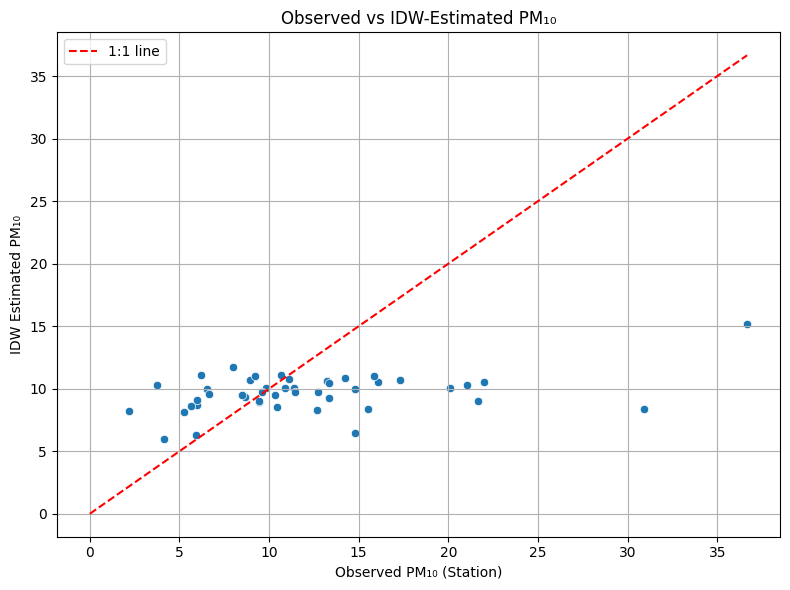

In [438]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=longtable2017, x='pm10', y='pm10_weighted')
# Add 1:1 reference line
max_val = max(longtable2017['pm10'].max(), longtable2017['pm10_weighted'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 line')

# Labels and title
plt.xlabel('Observed PM₁₀ (Station)')
plt.ylabel('IDW Estimated PM₁₀')
plt.title('Observed vs IDW-Estimated PM₁₀')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [439]:
print(set(camaras2018["time"].tolist()))

{Timestamp('2018-06-21 11:30:00'), Timestamp('2018-06-16 11:30:00'), Timestamp('2018-06-17 11:30:00'), Timestamp('2018-06-18 11:30:00'), Timestamp('2018-06-20 11:30:00'), Timestamp('2018-06-22 11:30:00'), Timestamp('2018-06-19 11:30:00')}


In [440]:
cams2018_cortado = camaras2018.iloc[10560:13200].copy()
cams2018_cortado.to_excel("cams/2018_cortado.xlsx")

geodata2018cams = gpd.GeoDataFrame(
    cams2018_cortado,
    geometry=gpd.points_from_xy(
        cams2018_cortado['3763_long'], 
        cams2018_cortado['3763_lat']
    ),
    crs="EPSG:3763"
)
print(cams2018_cortado.head())
print(cams2018_cortado.tail(5))

                      time   lat   lon       pm10      3763_long  \
448800 2018-06-20 11:30:00  36.5 -10.0  21.447265 -167265.612117   
448801 2018-06-20 11:30:00  36.5  -9.9  21.246418 -158305.172793   
448802 2018-06-20 11:30:00  36.5  -9.8  21.712890 -149344.875659   
448803 2018-06-20 11:30:00  36.5  -9.7  23.103515 -140384.712685   
448804 2018-06-20 11:30:00  36.5  -9.6  24.775390 -131424.675835   

             3763_lat  
448800 -350049.532044  
448801 -350218.603496  
448802 -350378.361097  
448803 -350528.806258  
448804 -350669.940311  
                      time   lat  lon       pm10      3763_long       3763_lat
451435 2018-06-20 11:30:00  43.0 -6.5  13.480224  133166.524410  371319.110964
451436 2018-06-20 11:30:00  43.0 -6.4  13.614583  141320.872736  371482.524421
451437 2018-06-20 11:30:00  43.0 -6.3  13.744872  149475.251732  371655.653689
451438 2018-06-20 11:30:00  43.0 -6.2  13.989013  157629.663144  371838.499941
451439 2018-06-20 11:30:00  43.0 -6.1  14.328938  16

In [441]:
print(geodata2018cams)

                      time   lat   lon       pm10      3763_long  \
448800 2018-06-20 11:30:00  36.5 -10.0  21.447265 -167265.612117   
448801 2018-06-20 11:30:00  36.5  -9.9  21.246418 -158305.172793   
448802 2018-06-20 11:30:00  36.5  -9.8  21.712890 -149344.875659   
448803 2018-06-20 11:30:00  36.5  -9.7  23.103515 -140384.712685   
448804 2018-06-20 11:30:00  36.5  -9.6  24.775390 -131424.675835   
...                    ...   ...   ...        ...            ...   
451435 2018-06-20 11:30:00  43.0  -6.5  13.480224  133166.524410   
451436 2018-06-20 11:30:00  43.0  -6.4  13.614583  141320.872736   
451437 2018-06-20 11:30:00  43.0  -6.3  13.744872  149475.251732   
451438 2018-06-20 11:30:00  43.0  -6.2  13.989013  157629.663144   
451439 2018-06-20 11:30:00  43.0  -6.1  14.328938  165784.108715   

             3763_lat                         geometry  
448800 -350049.532044  POINT (-167265.612 -350049.532)  
448801 -350218.603496  POINT (-158305.173 -350218.603)  
448802 -3503

In [442]:
geodataestacoes= gpd.GeoDataFrame(
    df_merged,
    geometry=gpd.points_from_xy(
        df_merged['3763_long'], 
        df_merged['3763_lat']
    ),
    crs="EPSG:3763"
)
print(geodataestacoes.iloc[:, :-3])

     codigo_est                      nome_estac  data_inici    data_fim  \
0   STA-PT01053                         Avintes  12/07/2010  0000/00/00   
1   STA-PT01021             Custóias-Matosinhos  01/09/1998  0000/00/00   
2   STA-PT01023               Ermesinde-Valongo  01/10/1998  0000/00/00   
3   STA-PT01024             D.Manuel II-Vermoim  01/11/1999  0000/00/00   
4   STA-PT01028  Francisco Sá Carneiro-Campanha  19/09/2000  0000/00/00   
..          ...                             ...         ...         ...   
60  STA-PT01054                    Anta-Espinho  25/02/2011  0000/00/00   
61  STA-PT01055                Seara-Matosinhos  23/01/2013  0000/00/00   
62  STA-PT03104    Cascais - Escola da Cidadela  22/01/2016  0000/00/00   
63  STA-PT01100                  Santa Combinha  01/05/2019  0000/00/00   
64  STA-PT03095                     Escavadeira  01/09/2001  0000/00/00   

     latitude  longitude   rede_codig  \
0   41.098187  -8.554351  NET-PT00015   
1   41.199805  -8

In [443]:
station_coords = np.array(list(geodataestacoes.geometry.apply(lambda geom: (geom.x, geom.y))))
cam_coords = np.array(list(geodata2017cams.geometry.apply(lambda geom: (geom.x, geom.y))))
print(station_coords[:5])
print(cam_coords[:5])
tree = cKDTree(cam_coords)
distances, indices = tree.query(station_coords, k=5)

[[-35388.72693303 158867.67731898]
 [-42924.77015087 170193.79623906]
 [-35183.61156175 170907.57384441]
 [-40710.86437655 174152.4663364 ]
 [-38417.07184248 166057.85841318]]
[[-167265.61211736 -350049.53204386]
 [-158305.17279284 -350218.60349628]
 [-149344.87565942 -350378.36109687]
 [-140384.71268495 -350528.80625844]
 [-131424.67583459 -350669.94031139]]


In [444]:
weighted_pm10 = []
for i in range(len(geodataestacoes)):
    dists = distances[i]
    idxs = indices[i]

    dists = np.where(dists == 0, 0.001, dists)
    weights = 1 / (dists**2)
    pm10_vals = geodata2018cams.iloc[idxs]['pm10'].values

    weighted_avg = np.average(pm10_vals, weights=weights)
    weighted_pm10.append({
        #'date': geodata2017cams.iloc[0]['time'], 
        'Estacao 2': geodataestacoes.iloc[i]['nome_estac'],
        'Estacao': geodataestacoes.iloc[i]['Estacao id'],
        'pm10_weighted': weighted_avg
    })

df = pd.DataFrame(weighted_pm10)
print(df)
longtable2018 = longtable2018.merge(df, on='Estacao', how='left')
longtable2018.to_excel("cams/idw2017.xlsx")

                         Estacao 2  Estacao  pm10_weighted
0                          Avintes     1053      21.891247
1              Custóias-Matosinhos     1021      23.388993
2                Ermesinde-Valongo     1023      22.682054
3              D.Manuel II-Vermoim     1024      22.949858
4   Francisco Sá Carneiro-Campanha     1028      23.032429
..                             ...      ...            ...
60                    Anta-Espinho     1054      20.646031
61                Seara-Matosinhos     1055      23.308810
62    Cascais - Escola da Cidadela     3104      28.203588
63                  Santa Combinha     1100       8.271668
64                     Escavadeira     3095      33.824171

[65 rows x 3 columns]


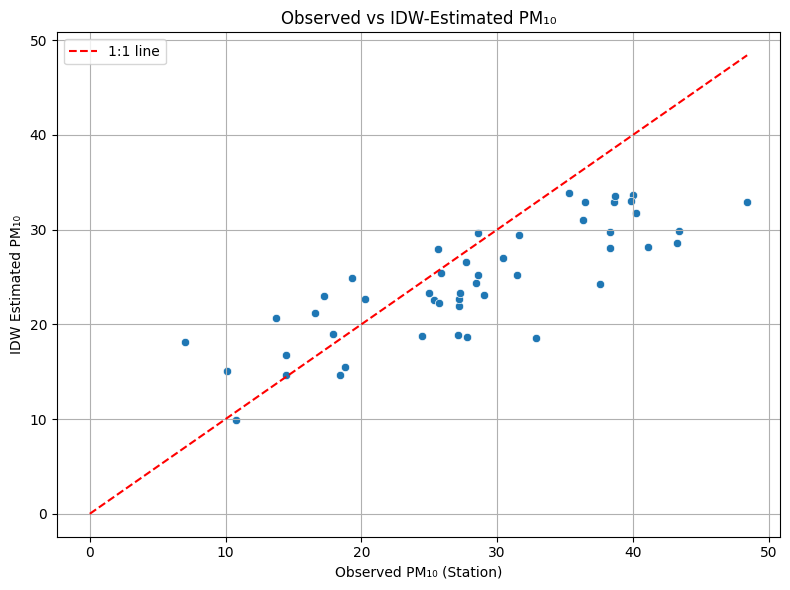

In [445]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=longtable2018, x='pm10', y='pm10_weighted')
# Add 1:1 reference line
max_val = max(longtable2018['pm10'].max(), longtable2018['pm10_weighted'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 line')

# Labels and title
plt.xlabel('Observed PM₁₀ (Station)')
plt.ylabel('IDW Estimated PM₁₀')
plt.title('Observed vs IDW-Estimated PM₁₀')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()